<a href="https://colab.research.google.com/github/jianna4/skindisease-detector/blob/main/skindisease2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
syedalinaqvi_augmented_skin_conditions_image_dataset_path = kagglehub.dataset_download('syedalinaqvi/augmented-skin-conditions-image-dataset')

print('Data source import complete.')


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras import Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout ,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os
import json
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness
from tensorflow.keras import Sequential


In [ ]:
# Set your dataset directory
dataset_dir = '/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions'#insert yours

# Load the dataset
dataset = image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42
)


Found 2394 files belonging to 6 classes.


In [ ]:
# Split dataset
train_size = 0.8
total_batches = tf.data.experimental.cardinality(dataset).numpy()
train_batches = int(train_size * total_batches)
train_dataset = dataset.take(train_batches)
test_dataset = dataset.skip(train_batches)
val_size = 0.1
val_batches = int(val_size * total_batches)
validation_dataset = test_dataset.take(val_batches)
test_dataset = test_dataset.skip(val_batches)


In [ ]:
#data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomBrightness(0.1)
])


In [ ]:
#applying the augmentation only on training dataset
def augment(images, labels):
    images = data_augmentation(images, training=True)
    return images, labels

train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# Prefetch for speed
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


In [ ]:
model = tf.keras.models.Sequential([
     # Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(0.0001),
           input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(256, activation='relu'),
    #Dropout(0.4),                 # VERY IMPORTANT
    Dense(6, activation='softmax')
])

# --- CALLBACKS ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # reduce LR by 50%
    patience=2,        # if val_loss doesn't improve for 2 epochs
    min_lr=1e-10,
    verbose=1
)

# Compile the model
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,       # 👈 PUT EPOCHS HERE
    batch_size=32,
    callbacks=[early_stop, reduce_lr]    # 👈 ADD CALLBACKS HERE
)

Epoch 1/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step - accuracy: 0.3748 - loss: 2.0187 - val_accuracy: 0.2723 - val_loss: 1.9406 - learning_rate: 1.0000e-05
Epoch 2/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 244ms/step - accuracy: 0.5475 - loss: 1.3308 - val_accuracy: 0.4688 - val_loss: 1.3901 - learning_rate: 1.0000e-05
Epoch 3/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - accuracy: 0.5864 - loss: 1.1940 - val_accuracy: 0.5357 - val_loss: 1.2470 - learning_rate: 1.0000e-05
Epoch 4/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.6192 - loss: 1.1009 - val_accuracy: 0.5536 - val_loss: 1.2789 - learning_rate: 1.0000e-05
Epoch 5/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 242ms/step - accuracy: 0.6529 - loss: 0.9594 - val_accuracy: 0.6161 - val_loss: 1.1052 - learning_rate: 1.0000e-05
Epoch 6/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.6678 - loss: 0.9416 - val_accuracy: 0.6027 - val_loss: 1.1810 - learning_rate: 1.0000e-05
Epoch 7/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/ste

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

# Save the model after evaluation

model.save("your_model.keras",include_optimizer=False)

print("Model saved as '/kaggle/working/your_model.keras")


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.6271 - loss: 1.1351
Test Loss: 1.1461989879608154
Test Accuracy: 0.6480000019073486
Model saved as '/kaggle/working/your_model.keras


In [ ]:


# Save the training history to a JSON file
history_dict = history.history
with open('training_history.json', 'w') as f:
    json.dump(history_dict, f)
print("Training history saved as training_history.json")


Training history saved as training_history.json


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
Classification Report:
              precision    recall  f1-score   support

        Acne       0.60      0.52      0.56        29
   Carcinoma       0.78      0.82      0.80        39
      Eczema       0.82      0.60      0.69        45
   Keratosis       0.58      0.80      0.67        45
       Milia       0.56      0.57      0.56        44
     Rosacea       0.75      0.69      0.72        48

    accuracy                           0.67       250
   macro avg       0.68      0.67      0.67       250
weighted avg       0.68      0.67      0.67       250

Confusion Matrix:
[[15  1  1  3  3  6]
 [ 0 32  0  4  3  0]
 [ 3  2 27  5  4  4]
 [ 0  3  3 36  3  0]
 [ 3  3  1 11 25  1]
 [ 4 

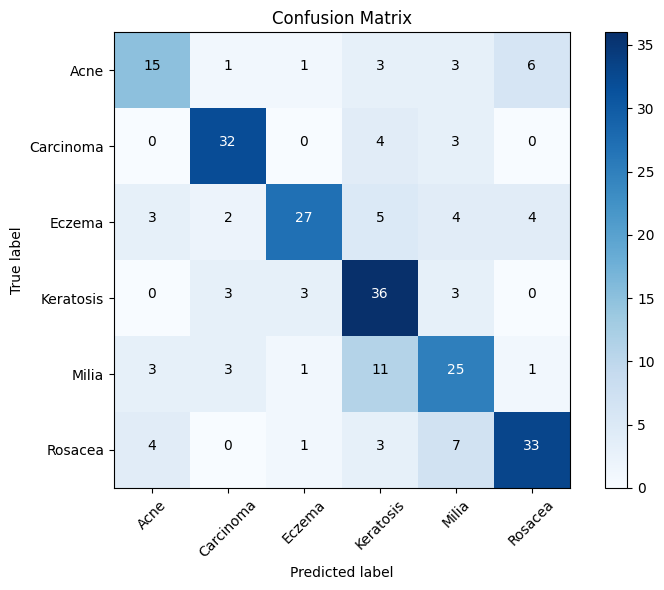

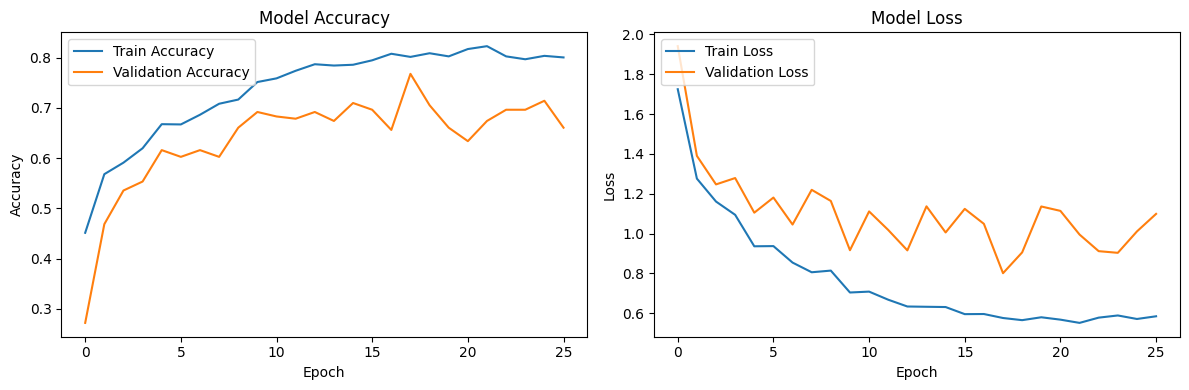

In [ ]:
# Generate predictions and create classification report
y_true, y_pred = [], []
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.class_names))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Function to Plot Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), ha="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=dataset.class_names, title='Confusion Matrix')
plt.show()

# Plot accuracy and loss curves
def plot_training_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to plot training curves
plot_training_curves(history_dict)


In [ ]:
import matplotlib.pyplot as plt

class_names = [
    'Acne',
    'Carcinoma',
    'Eczema',
    'Keratosis',
    'Milia',
    'Rosacea'
]

def plot_random_images(test_dataset, model, class_names, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for image_batch, label_batch in test_dataset.take(1):
        predictions = model.predict(image_batch)
        predicted_labels = np.argmax(predictions, axis=1)
        indices = np.random.choice(len(image_batch), num_images, replace=False)

        for idx, ax in enumerate(axes):
            img = image_batch[indices[idx]].numpy().astype(np.uint8)
            true_label = label_batch[indices[idx]].numpy()
            pred_label = predicted_labels[indices[idx]]

            ax.imshow(img)
            ax.axis('off')

            true_label_name = class_names[true_label]
            pred_label_name = class_names[pred_label]
            title_color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}", color=title_color, fontsize=12)

    plt.tight_layout()
    plt.show()

plot_random_images(test_dataset, model, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


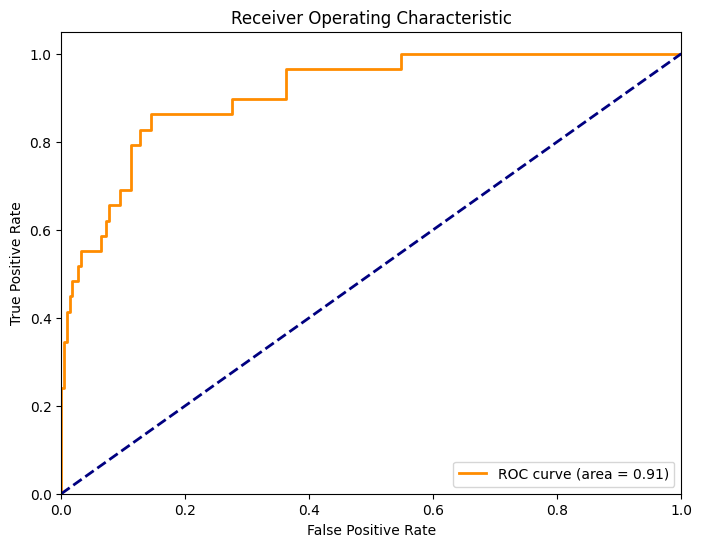

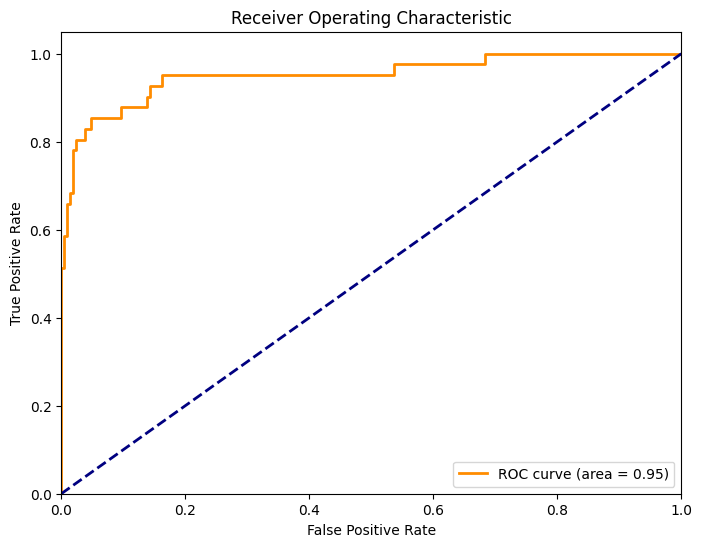

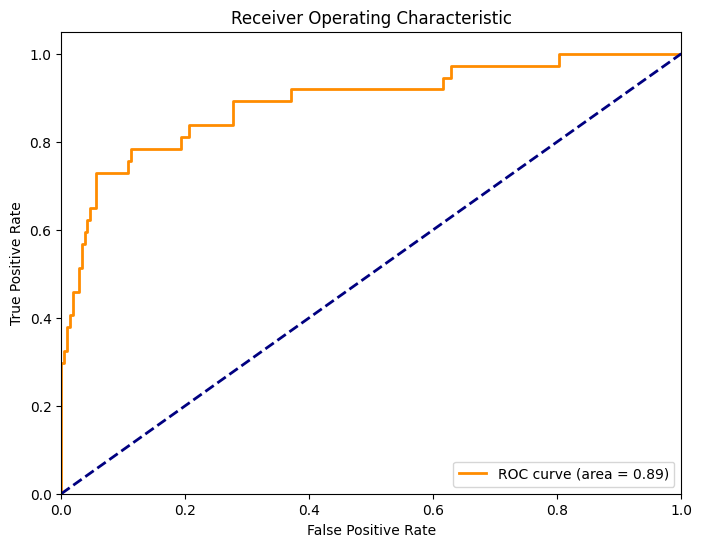

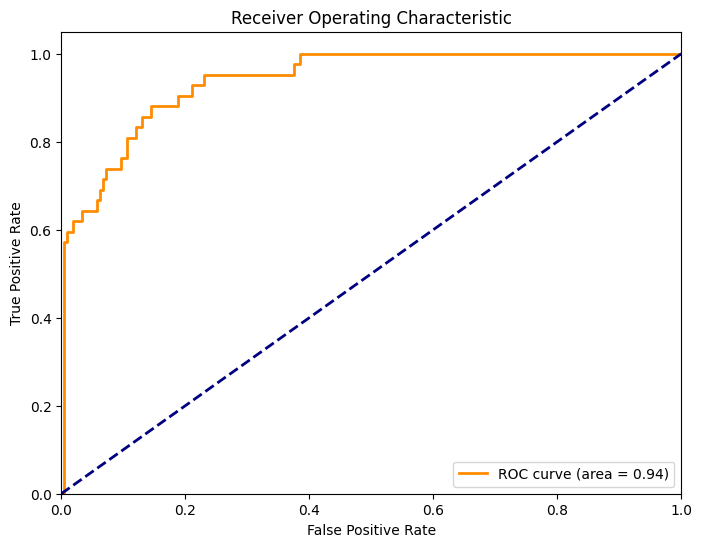

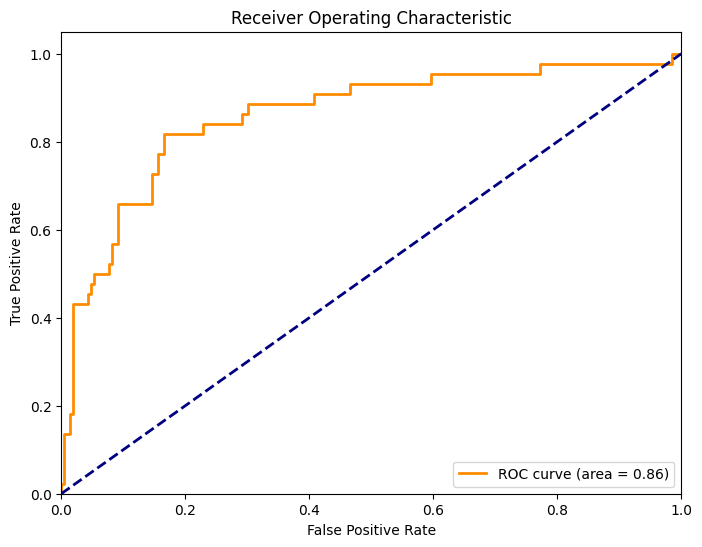

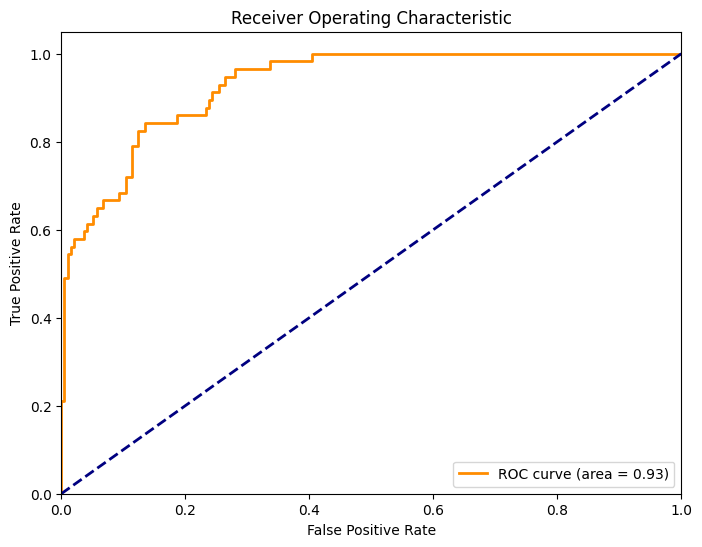

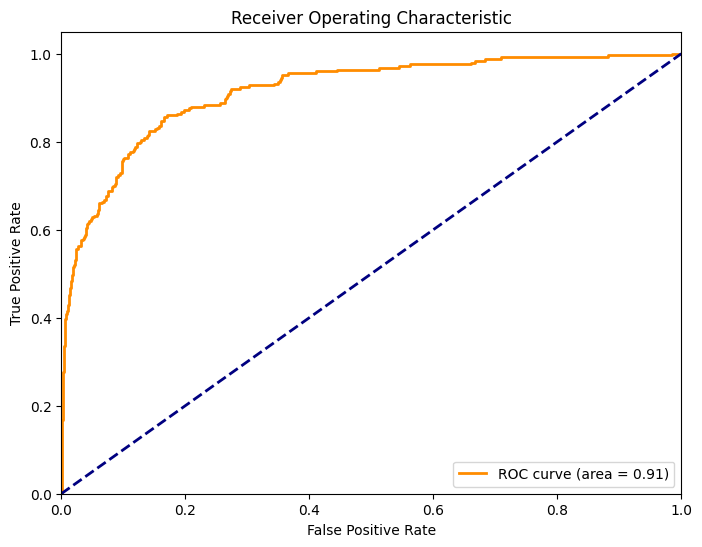

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to plot ROC curve for each class
def plot_roc_curve(fpr, tpr, auc, class_names):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Convert labels to one-hot encoding for ROC curve
y_true_one_hot = []
y_pred_probs = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true_one_hot.extend(labels.numpy())
    y_pred_probs.extend(preds)

y_true_one_hot = label_binarize(y_true_one_hot, classes=np.arange(len(dataset.class_names)))
y_pred_probs = np.array(y_pred_probs)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(dataset.class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
for i in range(len(dataset.class_names)):
    plot_roc_curve(fpr[i], tpr[i], roc_auc[i], dataset.class_names)

# Optionally, plot a macro-average ROC curve
fpr["macro"], tpr["macro"], _ = roc_curve(y_true_one_hot.ravel(), y_pred_probs.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plot_roc_curve(fpr["macro"], tpr["macro"], roc_auc["macro"], ["Macro Average"])
